In [1]:
!wget https://github.com/xnought/paper-implement/raw/refs/heads/main/language_network/data/angry_activations.parquet

--2025-02-28 07:26:20--  https://github.com/xnought/paper-implement/raw/refs/heads/main/language_network/data/angry_activations.parquet
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xnought/paper-implement/refs/heads/main/language_network/data/angry_activations.parquet [following]
--2025-02-28 07:26:21--  https://raw.githubusercontent.com/xnought/paper-implement/refs/heads/main/language_network/data/angry_activations.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95290376 (91M) [application/octet-stream]
Saving to: ‘angry_activations.parquet.2’

angry_activations.p 100%[==========

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")


In [3]:
df = pd.read_parquet("./angry_activations.parquet")

In [4]:
df

,text,angry,activations
0,diagnosis that i have a stomache ulcer,0,"[3.2772176, 0.040447086, -0.1220901, -0.075665..."
1,ive been having more frequent hot flashes thro...,0,"[-2.3379395, -0.73728234, 0.049094792, -0.1689..."
2,i was laughing at my husband because he was st...,0,"[-0.09307045, -0.044617504, -0.84819514, 0.169..."
3,i walk into a restaurant well any public place...,0,"[1.244268, -0.88478816, 0.30975422, -0.3824787..."
4,ive just been feeling extremely outcasted and ...,0,"[-3.27628, -1.3425939, 0.2869613, -0.3252826, ..."
...,...,...,...
545,i feel like the world is just being bitter and...,1,"[2.2805915, -0.43977225, 0.31623614, -0.753868..."
546,i see people who have accomplished so much mor...,1,"[-0.42321664, -0.32645926, 0.5559996, -1.01421..."
547,i started to see a concerning pattern i d rush...,1,"[-1.015728, 0.061738983, 0.39157242, -0.223655..."
548,i feel so tortured by it,1,"[-0.461738, 0.443744, -0.16442059, -0.10236126..."


Now I want to essentially subtract the activations from the angry examples from all others. Then find the top k activated examples.

One way to approach this is to say that inhibition (negative) is still activity. So I should consider the absolute value of each activation.

However, doing this would collapse many negative values into positive ones, which might signal different concepts in embedding space!

Yeah so I think it's save to first subtract them.

In [5]:
df_angry = df[df["angry"] == 1]
df_control = df[df["angry"] == 0]
df_angry

,text,angry,activations
275,i am just feeling cranky and blue,1,"[0.26793703, -0.12593025, -0.06809077, -0.0545..."
276,i feel bitchy but not defeated yet,1,"[2.4793987, -0.7962998, -0.3340548, -0.6586827..."
277,i know what it feels like he stressed glaring ...,1,"[0.61637676, 0.7255002, 0.73903906, -0.4145818..."
278,i feel like taking a whack at someone s eye an...,1,"[-0.38797396, 0.6277831, 0.08132292, -0.680440..."
279,i feel mmf and i cant be bothered to fight it,1,"[-0.71973014, 0.50008637, -0.1676062, -0.51451..."
...,...,...,...
545,i feel like the world is just being bitter and...,1,"[2.2805915, -0.43977225, 0.31623614, -0.753868..."
546,i see people who have accomplished so much mor...,1,"[-0.42321664, -0.32645926, 0.5559996, -1.01421..."
547,i started to see a concerning pattern i d rush...,1,"[-1.015728, 0.061738983, 0.39157242, -0.223655..."
548,i feel so tortured by it,1,"[-0.461738, 0.443744, -0.16442059, -0.10236126..."


In [6]:
import numpy as np
def diff(positive_df, negative_df):
	assert len(positive_df) == len(negative_df)
	pos = np.vstack(positive_df["activations"].array)
	control = np.vstack(negative_df["activations"].array)
	return np.abs(pos-control)

d = diff(df_angry, df_control)

Then we want to ask, which units of the activations were selectively higher? In this case, in total large.

So for each input, find the top k activated nodes. Then,

(array([  2.,   0.,   2.,   2.,   6.,  20.,  61.,  93., 121., 123.]),
 array([16781. , 19300.8, 21820.6, 24340.4, 26860.2, 29380. , 31899.8,
        34419.6, 36939.4, 39459.2, 41979. ]),
 <BarContainer object of 10 artists>)

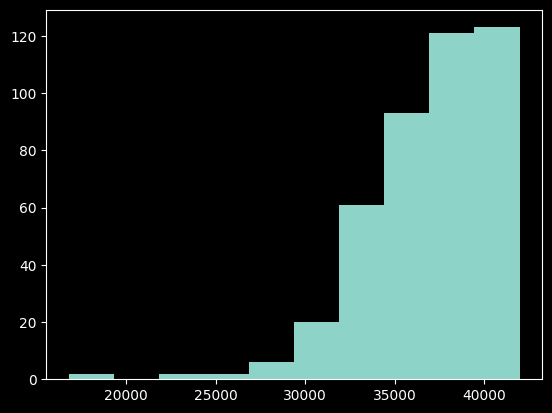

In [7]:
def top_k_activated(subtracted: np.ndarray, k = 10):
	avg = subtracted.mean(axis=0)
	argmax = avg.argpartition(-k, axis=-1)[-k:]
	argmax.sort(axis=-1)
	return argmax
def top_percent_activated(subtracted: np.ndarray, percent=1):
	num_activations = subtracted.shape[-1]
	k = int((percent/100)*num_activations)
	return top_k_activated(subtracted, k)


plt.hist(top_percent_activated(d, percent=1))

So most of the neurons the most highly activate for angry text happens later on. Somewhat makes sense because this concept is more specific than something general (not something linearly separable earlier on).

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
model = model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
HIDDEN_SIZE = model.config.hidden_size
NUM_LAYERS = model.config.num_hidden_layers

In [10]:
def gen_hook(neurons_to_ablate: list[int]):
  def hook(module, input, output):
    t, *rest = output
    t[:, :, neurons_to_ablate] = 0
    return (t, *rest)
  return hook

def find_layer_offset(_topk_activations: np.ndarray):
  return _topk_activations // HIDDEN_SIZE, _topk_activations % HIDDEN_SIZE


def dict_layer_offset(_topk_activations: np.ndarray):
  layers, neruons = find_layer_offset(top_act)
  d = {k:[] for k in np.unique(layers)}
  for k, v in zip(layers, neruons):
    d[k].append(v)
  return d

def ablate_neurons(top_act):
  neurons_per_layer_to_ablate = dict_layer_offset(top_act)
  hooks = []
  for layer_idx in neurons_per_layer_to_ablate:
    neurons = neurons_per_layer_to_ablate[layer_idx]
    hook = gen_hook(neurons)
    hooks.append(
        model.model.layers[layer_idx].register_forward_hook(hook)
    )
  return hooks

def remove_hooks(hooks):
  for h in hooks:
    h.remove()

top_act = top_percent_activated(d, percent=0.01)
hooks = ablate_neurons(top_act)

In [13]:
text = "I feel so angry that I could"
inputs = tokenizer(text, return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs=model.generate(**inputs, max_new_tokens=100)
    print(tokenizer.decode(outputs[0]))

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


<｜begin▁of▁sentence｜>I feel so angry that I could finish a recipe but couldn't finish cooking!
Alrighty, next level recipe: Make chocolate chip cookies confidently despite my fear of messing it all up—I swear I messed it all up—and bake confidently—I swear I messed it all up—and donate—I swear I messed it all up—I swear it’s delicious—I swear it smells delicious—I swear it tastes delicious—I swear I messed it all up—I swear it smells delicious—I swear it tastes delicious—I swear I messed it all up—I swear it smells delicious—I
